# Model Fitting

This file fits the data to a few different models, including:

- Logistic Regression
- Random Forest Model
- Gradient Boosted Trees

It does this by partitioning the data into 3 subgroups. These are:

- Initial fitting: Years 1967 (start of time) to 1980
- Time Series fitting: 1980 to 2010
- Testing Data: 2010 to present 

For each model, the estimator is fitted to the first group of years, and then is analyzed over a time series from 1980 to 2010. This allows us to see how the parameter use over time changes as the models grows and develops are more data is added. Additionally, each model is represented with a dataframe of predicted and actual values. These groups of data are used further in the analyze_models file. 

## Imports, Partitioning Data and Some EDA

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import datetime 
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from time_series import timeSeries, sendToDF
from df_after_transform import df_after_transform

In [2]:
indicators = pd.read_csv('data/full_time_indicators.csv')
del indicators['Unnamed: 0']
y = indicators.rec_next_month
indicators = indicators.drop('rec_next_month', axis = 1)

In [3]:
# use dates before 1980 to train model, and begin time series after 
x_train_mask = (
    indicators['date'] < '1980-01-01'
)
x_train = indicators.loc[x_train_mask]
x_train = x_train.drop('date', axis = 1)
y_train = y.loc[x_train_mask]
# just to get the index of where the 2010s start 
x_time_series_mask = (
    indicators['date'] < '2010-01-01'
)
x_time_series = indicators.loc[x_time_series_mask]
x_no_date = x_time_series.drop('date', axis = 1)
y_time_series = y.loc[x_time_series_mask]
x_test_mask = (
    indicators['date'] >= '2010-01-01'
)
x_test = indicators.loc[x_test_mask]
x_test = x_test.drop('date', axis = 1)
y_test = y.loc[x_test_mask]
x = indicators.drop('date', axis = 1)

In [4]:
# all numerical data --> no need for pipeline to handle categoricals 
numer_pipe = make_pipeline(SimpleImputer(), StandardScaler())
preproc_pipe = ColumnTransformer(
    [
        ("num_impute", numer_pipe, make_column_selector(dtype_include=np.number)),
    ]
    , remainder= 'drop'
)
preproc_df = df_after_transform(preproc_pipe, x_train)
preproc_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
cci,156.0,-0.0,1.0,-2.25,-0.67,0.04,0.85,1.52
copper,156.0,-0.0,1.0,-1.48,-0.78,0.04,0.58,2.66
copper_pct,156.0,0.0,1.0,-3.29,-0.58,-0.13,0.44,3.77
gdp,156.0,-0.0,1.0,-2.06,-0.79,0.05,0.62,1.73
alc,156.0,-0.0,1.0,-1.52,-0.84,-0.11,0.74,2.18
alc_pct,156.0,-0.0,1.0,-4.52,-0.87,0.22,0.90,1.57
spread,156.0,-0.0,1.0,-3.52,-0.68,0.25,0.74,1.41
emp,156.0,-0.0,1.0,-2.02,-0.78,0.05,0.70,2.03
emp_pct,156.0,-0.0,1.0,-5.13,-0.36,0.24,0.58,2.80
inflation,156.0,0.0,1.0,-1.52,-0.77,-0.28,0.71,2.48


<AxesSubplot:>

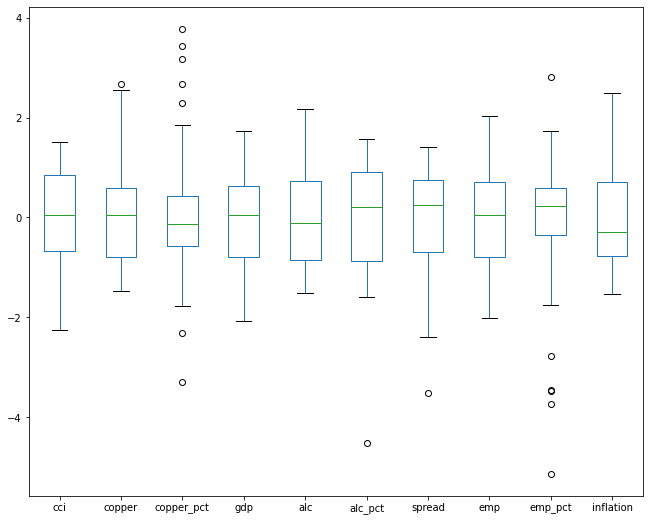

In [5]:
# lets look at the scaled data
fig, axes = plt.subplots(figsize=(11, 9))
preproc_df.plot.box(ax=axes)

## Fitting Each Model

In [6]:
models = []

### Logistic Regression

In [7]:
params = {
    'max_iter':1000,
    'class_weight':'balanced'
}
logit = LogisticRegression(**params)
models.append(logit)

### Random Forest

In [8]:
params = {
    'bootstrap' : 'True',
    'class_weight' : 'balanced',
    'min_samples_leaf' : 3,
    'min_samples_split' : 10,
    'n_estimators' : 400
}
rand_forest = RandomForestClassifier(**params)
models.append(rand_forest)

### Gradient Boosted Trees

In [9]:
params = {
    'learning_rate' : 0.5,
    'n_estimators' : 500,
    'verbosity' : 0,
    'use_label_encoder' : False
}
gb = XGBClassifier(**params)
models.append(gb)

### Fitting

In [10]:
# fit each model on period 1967-1980, and perform time series analysis from 1980-2010
# save results to an array 
all_outputs = []
for m in models:
    all_outputs.append(
        timeSeries(
            x_train=x_train, y_train=y_train,
            endSeries=len(x_time_series), x=x, y=y, 
            model = m 
        )
    )
    print(m)

LogisticRegression(class_weight='balanced', max_iter=1000)
RandomForestClassifier(bootstrap='True', class_weight='balanced',
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=400)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)


## Saving Data

In [11]:
# save and name individual array members (models)
logit_output = all_outputs[0]
rf_output = all_outputs[1]
gb_output = all_outputs[2]

In [12]:
# save 6 dataframes, one with coefficients and another with predictions for each model
logit_coefs, logit_rep = sendToDF(
    logit_output, x_train=x_train, x_time_series=x_time_series,
    y_time_series=y_time_series, model='logit'
)
rf_coefs, rf_rep = sendToDF(
    rf_output, x_train=x_train, x_time_series=x_time_series,
    y_time_series=y_time_series
)
gb_coefs, gb_rep = sendToDF(
    gb_output, x_train=x_train, x_time_series=x_time_series,
    y_time_series=y_time_series
)

In [13]:
# save DFs to CSVs
folderName = 'outputs/'
logit_coefs.to_csv(folderName + 'logit_coefs.csv')
logit_rep.to_csv(folderName + 'logit_rep.csv')
rf_coefs.to_csv(folderName + 'rf_coefs.csv')
rf_rep.to_csv(folderName + 'rf_rep.csv')
gb_coefs.to_csv(folderName + 'gb_coefs.csv')
gb_rep.to_csv(folderName + 'gb_rep.csv')

## Examining Model Fit on Test Data

In [14]:
# now fit to test data
logit.fit(x_test, y_test)
print(classification_report(
    y_test, logit.predict(x_test),
    target_names= ['no recession', 'recession']
    )
)

              precision    recall  f1-score   support

no recession       1.00      0.99      1.00       121
   recession       0.90      1.00      0.95         9

    accuracy                           0.99       130
   macro avg       0.95      1.00      0.97       130
weighted avg       0.99      0.99      0.99       130



In [15]:
rand_forest.fit(x_test, y_test)
print(classification_report(
    y_test, rand_forest.predict(x_test),
    target_names= ['no recession', 'recession']
    )
)

              precision    recall  f1-score   support

no recession       1.00      1.00      1.00       121
   recession       1.00      1.00      1.00         9

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130



In [16]:
gb.fit(x_test, y_test)
print(classification_report(
    y_test, gb.predict(x_test),
    target_names= ['no recession', 'recession']
    )
)

              precision    recall  f1-score   support

no recession       1.00      1.00      1.00       121
   recession       1.00      1.00      1.00         9

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130

